In [1]:
# import matplotlib.pyplot as plt
import csv
import math
import plotly.graph_objects as go
import numpy as np
from jupyter_client.connect import channel_socket_types
from prompt_toolkit.key_binding.bindings.named_commands import uppercase_word
import pandas as pd
from scipy.fft import fft, ifft
from experiment_loader import load_2d_experiment, load_3d_experiment
from modeling import *
# plt.rcParams['figure.figsize'] = [25, 15]

In [2]:
PLOT_WIDTH = 2000
PLOT_HEIGHT = 1000

In [3]:
channels, channel_meas = load_2d_experiment("./lut_channnel_sweep.csv")
filters, filter_meas = load_2d_experiment("./lut_filter_sweep.csv")
inputs, input_meas = load_2d_experiment("./lut_input_sweep.csv")
channel_cf, filters_cf, channel_filter_meas = load_3d_experiment("./lut_channel_filter_sweep.csv")

In [4]:
with open('./lut_filter_sweep.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    rows = list(spamreader)
    filters = [int(row[0]) for row in rows]
    filter_meas = [float(row[1]) for row in rows]
fig = go.Figure()
fig.add_trace(go.Scatter(x=filters, y=filter_meas, name="Filter Measurements"))

fig.update_layout(
    autosize=False,
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
)

In [5]:
with open('./consuming_channnel_sweep.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    rows = list(spamreader)
    filters = [int(row[0]) for row in rows]
    filter_meas = [float(row[1]) for row in rows]
fig = go.Figure()
fig.add_trace(go.Scatter(x=filters, y=filter_meas, name="Filter Measurements"))

fig.update_layout(
    autosize=False,
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
)

In [6]:


# Read data from a csv
df = pd.read_csv('./lut_channel_filter_sweep.csv', usecols=["channels", "filters", "ms"])
split_df = df.groupby('channels')
fig = go.Figure()

x_unique = list(set(df["channels"]))
x_unique.sort()
y_unique = list(set(df["filters"]))
y_unique.sort()
# print(y_unique)
z = []
for y in y_unique:
    z.append([])
    for x in x_unique:
        z[-1].append(df.loc[df["channels"] == x].loc[df["filters"] == y]["ms"].values[0])
# np.reshape([x.shape[0], y.shape[0]])
# print(z)
fig.add_trace(go.Scatter3d(
    x=df['channels'],
    y=df['filters'],
    z=df['ms'],
    mode='markers',
    marker=dict(size=7),
    # name=f"channel {category}",
    # mode='markers+lines',
    line=dict(
        dash='dash',
        width=.5
    )
))
fig.add_trace(go.Surface(
    x=x_unique,
    y=y_unique,
    z=z,
))
# Customize the plot
fig.update_layout(
    scene=dict(
        xaxis_title='channels',
        yaxis_title='filters',
        zaxis_title='ms'
    ),
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
        template='plotly_white',
)
fig.layout.scene.camera.projection.type = "orthographic"
# Display the plot
fig.show()


In [9]:
fig = go.Figure()
split_df = df.groupby('channels')
first = True
# deltas = []
# approx = split_df.get_group(100)

# lv = list(approx['ms'])[0]
# for meas in list(approx['ms'])[1:]:
#     deltas.append((meas / lv))
#     lv = meas
deltas = calculate_deltas(list(split_df.get_group(120)['ms']))
for category, category_df in split_df:
    # print(category_df)
    # if not first:
    #    continue
    upper_right = 195
    upper_left = 129
    lower_right = 192
    lower_left = 126
    # # upper_m, upper_b = lin_interpol( upper_sampled_channels[0], upper_sampled_channels[1], upper_sampled_channel_meas[0], upper_sampled_channel_meas[1])

    upper_right_meas = category_df.loc[category_df["filters"] == upper_right]["ms"].values[0]
    upper_left_meas = category_df.loc[category_df["filters"] == upper_left]["ms"].values[0]

    lower_right_meas = category_df.loc[category_df["filters"] == lower_right]["ms"].values[0]
    lower_left_meas = category_df.loc[category_df["filters"] == lower_left]["ms"].values[0]

    # print(upper_right_meas)
    # print(upper_left_meas)

    upper_m, upper_b = lin_interpol(upper_left - 3, upper_right - 3, upper_left_meas, upper_right_meas)
    lower_m, lower_b = lin_interpol(lower_left, lower_right, lower_left_meas, lower_right_meas)
    # print(list(category_df['channels']))
    # print(list(range(category_df['channels'][0], list(category_df['channels'])[-1])))
    start = list(category_df['filters'])[0]
    end = list(category_df['filters'])[-1]
    r_c = list(range(start, end))

    # r_v_upper = [calc_upper(c, upper_m, upper_b) for c in r_c]
    # r_v_lower = [calc_lower(c, lower_m, lower_b) for c in r_c]

    # fig.add_trace(go.Scatter(x=r_c, y=[c * upper_m + upper_b for c in r_c], name="Upper Sampled Channels"))
    # fig.add_trace(go.Scatter(x=r_c, y=[c * lower_m + lower_b for c in r_c], name="Lower Sampled Channels"))
    r_v_rect = [calc_rect(c, upper_m, upper_b, lower_m, lower_b) for c in r_c]
    lv = list(category_df['ms'])[0]
    delta_approx = [lv]
    for delta in deltas:
        lv = delta * lv
        delta_approx.append(lv)
        
    errs = [(1 - (g / m)) * 100 for g, m in zip(delta_approx, list(category_df['ms']))]
    all_errs = []
    all_errs.append(np.mean(np.abs(errs)))

    print(np.mean(np.abs(errs)))
    fig.add_trace(go.Scatter(
        # x=category_df['channels'],
        x=category_df['filters'],
        y=category_df['ms'],
        # mode='markers',
        marker=dict(size=7),
        name=f"filter {category}",
        mode='markers+lines',
        line=dict(
            dash='dash',
            width=.5
        )
    ))
    fig.add_trace(go.Scatter(
        x=list(category_df['filters']),
        y=delta_approx,
        name=f"delta_approx {category}",
        mode='lines',
    ))
    
    fig.add_trace(go.Scatter(
        x=list(category_df['filters']),
        y=errs,
        name=f"delta_approx err {category}",
        mode='lines',
    ))

    first = False
print(f"{np.mean(all_errs)=}")

fig.update_layout(
    scene=dict(
        xaxis_title='filters',
        yaxis_title='filters',
        zaxis_title='ms'
    ),
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
        template='plotly_white',
)
fig.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

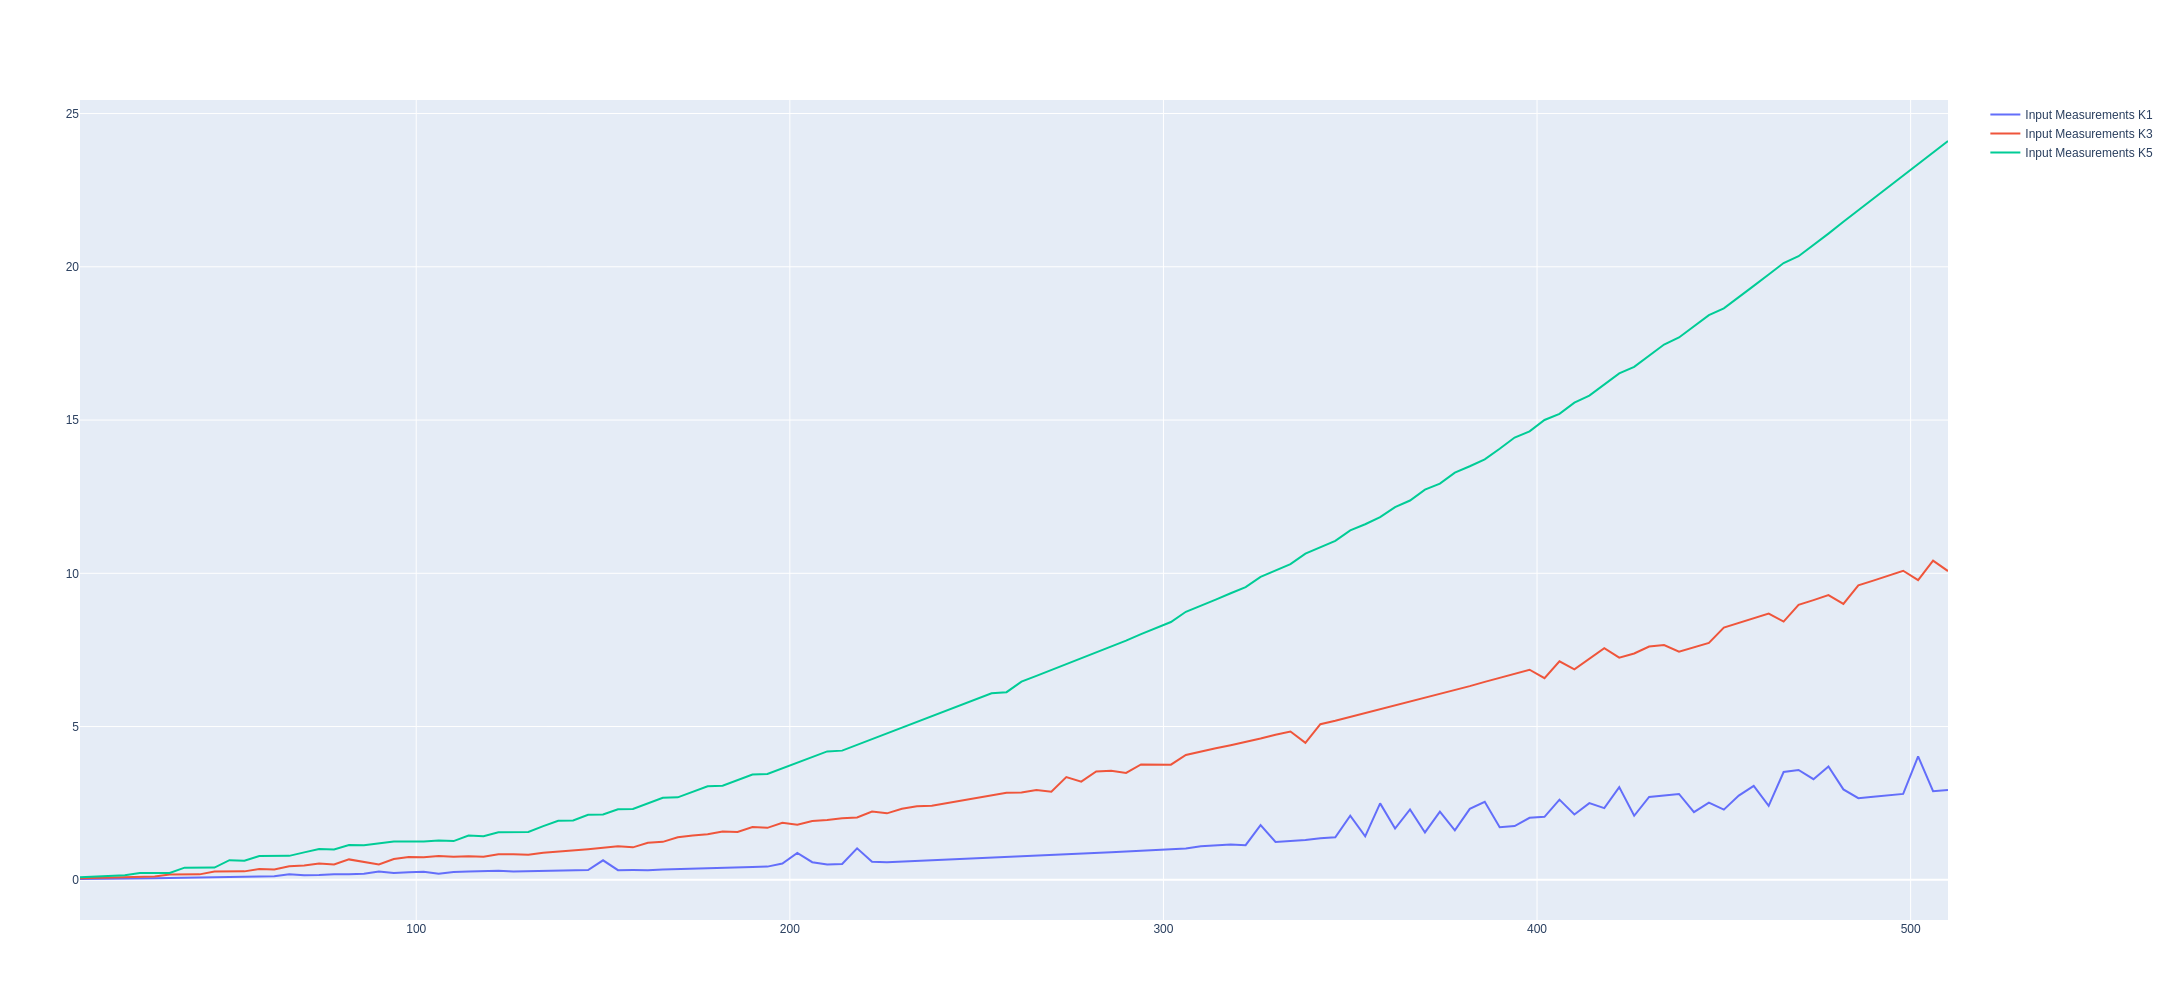

In [12]:
filenames = ["lut_input_sweep_K1x1.csv", "lut_input_sweep_K3x3.csv", "lut_input_sweep_K5x5.csv"]
fig = go.Figure()
# deltas = calculate_deltas(list(split_df.get_group(120)['ms']))
inputs_k1, inputs_k1_meas = load_2d_experiment("lut_input_sweep_K1x1.csv")
inputs_k3, inputs_k3_meas = load_2d_experiment("lut_input_sweep_K3x3.csv")
inputs_k5, inputs_k5_meas = load_2d_experiment("lut_input_sweep_K5x5.csv") 

fig.add_trace(go.Scatter(x=inputs_k1, y=inputs_k1_meas, name=f"Input Measurements K1"))
fig.add_trace(go.Scatter(x=inputs_k3, y=inputs_k3_meas, name=f"Input Measurements K3"))
fig.add_trace(go.Scatter(x=inputs_k5, y=inputs_k5_meas, name=f"Input Measurements K5"))

fig.update_layout(
    autosize=False,
width=PLOT_WIDTH,
height=PLOT_HEIGHT,
    # margin=dict(
    #     l=50,
    #     r=50,
    #     b=100,
    #     t=100,
    #     pad=4
    # ),
    )
fig.show()